In [165]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import re
import time

In [166]:
with c3_open("MasterData_V5.csv", 'r') as f:
    masterData = pd.read_csv(f, )

### Utility functions

In [167]:
# WP2 gives all the descriptive statistics for the list of metrics state-wise

def descriptiveStatForMetrics(data, metricList):
    
    '''
    1. convert date column to datetime type
    2. sort and group the data by state
    3. sort the grouped data by date
    4. create dataframe having state, metric, min, max, median, mean, std, nr_missing, nr_neg_daily
    5. for each state
        1. loop the metric in metricList
        2. for each metric compute the descriptive statistics, no of neg counts 
           and missing values
        3. append the result dataframe to new dataframe
        4. del the result dataframe
    '''
    data["date"] = pd.to_datetime(data["date"], format="%d/%m/%Y")
    data = data.groupby('state', sort=True).apply(pd.DataFrame.sort_values, 'date').reset_index(drop=True)
    descStatDf = pd.DataFrame()
    for metric in metricList:
        data[metric+"_dailyNewCases"] = data.groupby("state")[metric].diff()
        data[metric+"_negFlag"] = (data.groupby("state")[metric].diff() < 0).astype(int)
        temp = data.groupby("state")[metric].describe().reset_index()
        temp.insert(1, "metric", metric)
        temp["negFlagCount"]= data.groupby("state")[metric+"_negFlag"].sum().values
        temp["noOfDaysDataMissn"] = ((data.groupby("state")[metric+".missing"].sum())/100).astype(int).values
        descStatDf = descStatDf.append(temp)
        del temp
    return data, descStatDf


In [168]:
# WP2 gives all the descriptive statistics for the list of metrics state-wise

def descriptiveStatForNormMetrics(data, metricList):
    
    '''
    1. convert date column to datetime type
    2. sort and group the data by state
    3. sort the grouped data by date
    4. create dataframe having state, metric, min, max, median, mean, std, nr_missing, nr_neg_daily
    5. for each state
        1. loop the metric in metricList
        2. for each metric compute the descriptive statistics
           and missing values
        3. append the result dataframe to new dataframe
        4. del the result dataframe
    '''
    data["date"] = pd.to_datetime(data["date"])
    data = data.groupby('state', sort=True).apply(pd.DataFrame.sort_values, 'date').reset_index(drop=True)
    descStatDf = pd.DataFrame()
    for metric in metricList:
        temp = data.groupby("state")[metric].describe().reset_index()
        temp.insert(1, "metric", metric)
        temp["noOfDaysDataMissn"] = ((data.groupby("state")[metric+".missing"].sum())/100).astype(int).values if (metric+".missing" in data.columns) else (data.set_index('state')[metric].isna().sum(level=0)).astype(int).values 
        descStatDf = descStatDf.append(temp)
        del temp
    return data, descStatDf


In [169]:
# WP2 gives all the correlation matrix for the list of metrics state-wise
def corrMatrixStateWise(data, metricList):
    
    '''
    1. for each state
        1. filter the data based on each state
        2. compute the pearson correlation coef
        3. append the result dataframe to new dataframe
        4. insert new column having the value of state
        5. del the result dataframe
        6. aggregated correlation matrix for all states
    '''
    data["date"] = pd.to_datetime(data["date"])
    data = data.groupby('state', sort=True).apply(pd.DataFrame.sort_values, 'date').reset_index(drop=True)
    corrDf = pd.DataFrame()
    aggCorrDf = pd.DataFrame()
    for state in data["state"].unique().tolist():
        temp = data[data["state"]==state]
        temp = temp[metricList].corr()
        aggCorrDf = temp.copy() if aggCorrDf.empty else (aggCorrDf + temp.copy())
        temp.reset_index(inplace=True)
        temp.insert(0, "state", state)
        corrDf = corrDf.append(temp)
        del temp
    aggCorrDf = aggCorrDf/data["state"].nunique()
    return corrDf, aggCorrDf

### Generate report for all non cumulative numeric features

In [170]:
data = masterData.copy()
metricList = ["UniversityOfWashington_AdmisMean", "UniversityOfWashington_AllbedMean", "OIET_Affinity_SpendAcf", "OIET_Affinity_SpendAer", "OIET_Affinity_SpendAll", "OIET_Affinity_SpendApg", "OIET_Affinity_SpendGrf", "OIET_Affinity_SpendHcs", "OIET_Affinity_SpendTws", "OIET_Affinity_SpendAllInchigh", "OIET_Affinity_SpendAllInclow", "OIET_Affinity_SpendAllIncmiddle", "OIET_BurningGlass_BgPosts", "OIET_BurningGlass_BgPostsSs30", "OIET_BurningGlass_BgPostsSs55", "OIET_BurningGlass_BgPostsSs60", "OIET_BurningGlass_BgPostsSs65", "OIET_BurningGlass_BgPostsSs70", "OIET_BurningGlass_BgPostsJz1", "OIET_BurningGlass_BgPostsJz2", "OIET_BurningGlass_BgPostsJz3", "OIET_BurningGlass_BgPostsJz4", "OIET_BurningGlass_BgPostsJz5", "OIET_UIClaims_InitialClaims", "OIET_UIClaims_InitialClaimsRate", "OIET_UIClaims_TotalClaims", "OIET_UIClaims_TotalClaimsRate", "OIET_Employment_All", "OIET_Employment_IncLow", "OIET_Employment_IncMiddle", "OIET_Employment_IncHigh", "OIET_Employment_ss40", "OIET_Employment_ss60", "OIET_Employment_ss65", "OIET_Employment_ss70", "OIET_WomplyMerchants_MerchantsAll", "OIET_WomplyMerchants_MerchantsInchigh", "OIET_WomplyMerchants_MerchantsInclow", "OIET_WomplyMerchants_MerchantsIncmiddle", "OIET_WomplyMerchants_MerchantsSs60", "OIET_WomplyMerchants_MerchantsSs65", "OIET_WomplyMerchants_MerchantsSs70", "OIET_WomplyRevenue_RevenueAll", "OIET_WomplyRevenue_RevenueInchigh", "OIET_WomplyRevenue_RevenueInclow", "OIET_WomplyRevenue_RevenueIncmiddle", "OIET_WomplyRevenue_RevenueSs40", "OIET_WomplyRevenue_RevenueSs60", "OIET_WomplyRevenue_RevenueSs65", "OIET_WomplyRevenue_RevenueSs70", "OIET_LowIncEarningsSmallBusinesses_Pay", "OIET_LowIncEarningsSmallBusinesses_Pay31To33", "OIET_LowIncEarningsSmallBusinesses_Pay44To45", "OIET_LowIncEarningsSmallBusinesses_Pay48To49", "OIET_LowIncEarningsSmallBusinesses_Pay62", "OIET_LowIncEarningsSmallBusinesses_Pay72", "OIET_LowIncEarningsSmallBusinesses_PayInclow", "OIET_LowIncEarningsSmallBusinesses_PayIncmiddle", "OIET_LowIncEarningsSmallBusinesses_PayInchigh", "OIET_LowIncEarningsAllBusinesses_Pay", "OIET_LowIncEarningsAllBusinesses_Pay31To33", "OIET_LowIncEarningsAllBusinesses_Pay44To45", "OIET_LowIncEarningsAllBusinesses_Pay48To49", "OIET_LowIncEarningsAllBusinesses_Pay62", "OIET_LowIncEarningsAllBusinesses_Pay72", "OIET_LowIncEarningsAllBusinesses_PayInclow", "OIET_LowIncEarningsAllBusinesses_PayIncmiddle", "OIET_LowIncEarningsAllBusinesses_PayInchigh", "OIET_LowIncEmpAllBusinesses_Emp", "OIET_LowIncEmpAllBusinesses_Emp31To33", "OIET_LowIncEmpAllBusinesses_Emp44To45", "OIET_LowIncEmpAllBusinesses_Emp48To49", "OIET_LowIncEmpAllBusinesses_Emp62", "OIET_LowIncEmpAllBusinesses_Emp72", "OIET_LowIncEmpAllBusinesses_EmpInclow", "OIET_LowIncEmpAllBusinesses_EmpIncmiddle", "OIET_LowIncEmpAllBusinesses_EmpInchigh", "OIET_LowIncEmpSmallBusinesses_Emp", "OIET_LowIncEmpSmallBusinesses_Emp31To33", "OIET_LowIncEmpSmallBusinesses_Emp44To45", "OIET_LowIncEmpSmallBusinesses_Emp48To49", "OIET_LowIncEmpSmallBusinesses_Emp62", "OIET_LowIncEmpSmallBusinesses_Emp72", "OIET_LowIncEmpSmallBusinesses_EmpInclow", "OIET_LowIncEmpSmallBusinesses_EmpIncmiddle", "OIET_LowIncEmpSmallBusinesses_EmpInchigh", "Realtor_AvgMedianListingPrice", "Realtor_AvgMedianListingPricePerSquareFeet", "Realtor_ActiveListingCount", "Realtor_NewListingCount", "Realtor_PriceIncreasedCount", "Realtor_PriceReducedCount", "Realtor_PendingListingCount", "Realtor_TotalListingCount", "Realtor_AvgMedianDaysOnMarket", "Realtor_AvgMedianSquareFeet", "Realtor_AvgPendingRatio", "Realtor_AverageListingPrice", "Realtor_AvgPercentChangeMedianListingPriceMm", "Realtor_AvgPercentChangeMedianListingPriceYy", "Apple_DrivingMobility", "Apple_WalkingMobility", "Apple_TransitMobility", "Google_GroceryMobility", "Google_ParksMobility", "Google_TransitStationsMobility", "Google_RetailMobility", "Google_ResidentialMobility", "Google_WorkplacesMobility", "PlaceIQ_DeviceCount", "PlaceIQ_DeviceExposure", "PlaceIQ_DeviceCount_Adjusted", "PlaceIQ_DeviceExposure_Adjusted", "PlaceIQ_DeviceCount_Education1_Adjusted", "PlaceIQ_DeviceExposure_Education1_Adjusted", "PlaceIQ_DeviceCount_Education2_Adjusted", "PlaceIQ_DeviceExposure_Education2_Adjusted", "PlaceIQ_DeviceCount_Education3_Adjusted", "PlaceIQ_DeviceExposure_Education3_Adjusted", "PlaceIQ_DeviceCount_Education4_Adjusted", "PlaceIQ_DeviceExposure_Education4_Adjusted", "PlaceIQ_DeviceCount_Income1_Adjusted", "PlaceIQ_DeviceExposure_Income1_Adjusted", "PlaceIQ_DeviceCount_Income2_Adjusted", "PlaceIQ_DeviceExposure_Income2_Adjusted", "PlaceIQ_DeviceCount_Income3_Adjusted", "PlaceIQ_DeviceExposure_Income3_Adjusted", "PlaceIQ_DeviceCount_Income4_Adjusted", "PlaceIQ_DeviceExposure_Income4_Adjusted", "PlaceIQ_DeviceCount_RaceAsian_Adjusted", "PlaceIQ_DeviceExposure_RaceAsian_Adjusted", "PlaceIQ_DeviceCount_RaceBlack_Adjusted", "PlaceIQ_DeviceExposure_RaceBlack_Adjusted", "PlaceIQ_DeviceCount_RaceHispanic_Adjusted", "PlaceIQ_DeviceExposure_RaceHispanic_Adjusted", "PlaceIQ_DeviceCount_RaceWhite_Adjusted", "PlaceIQ_DeviceExposure_RaceWhite_Adjusted", "PlaceIQ_DeviceCount_Income3", "PlaceIQ_DeviceExposure_Income3", "PlaceIQ_DeviceCount_Income4", "PlaceIQ_DeviceExposure_Income4", "PlaceIQ_DeviceCount_RaceAsian", "PlaceIQ_DeviceExposure_RaceAsian", "PlaceIQ_DeviceCount_RaceBlack", "PlaceIQ_DeviceExposure_RaceBlack", "PlaceIQ_DeviceCount_RaceHispanic", "PlaceIQ_DeviceExposure_RaceHispanic", "PlaceIQ_DeviceCount_RaceWhite", "PlaceIQ_DeviceExposure_RaceWhite", "AverageDailyTemperature", "AverageDewPoint", "AverageRelativeHumidity", "AverageSurfaceAirPressure", "AveragePrecipitation", "AverageWindSpeed", "AverageWindDirection", "AverageHorizontalVisibility", "AverageWindGustSpeed", "AverageSnow", "AveragePrecipitationTotal", "AveragePressureTendency", "OxCGRT_Policy_C1_SchoolClosing", "OxCGRT_Policy_C2_WorkplaceClosing", "OxCGRT_Policy_C3_CancelPublicEvents", "OxCGRT_Policy_C4_RestrictionsOnGatherings", "OxCGRT_Policy_C5_ClosePublicTransport", "OxCGRT_Policy_C6_StayAtHomeRequirements", "OxCGRT_Policy_C7_RestrictionsOnInternalMovement", "OxCGRT_Policy_C8_InternationalTravelControls", "OxCGRT_Policy_E1_IncomeSupport", "OxCGRT_Policy_E2_DebtContractRelief", "OxCGRT_Policy_E3_FiscalMeasures", "OxCGRT_Policy_E4_InternationalSupport", "OxCGRT_Policy_H1_PublicInformationCampaigns", "OxCGRT_Policy_H2_TestingPolicy", "OxCGRT_Policy_H3_ContactTracing", "OxCGRT_Policy_H4_EmergencyInvestmentInHealthcare", "OxCGRT_Policy_H5_InvestmentInVaccines", "OxCGRT_Policy_M1_Wildcard", "OxCGRT_Policy_ConfirmedCases", "OxCGRT_Policy_ConfirmedDeaths", "OxCGRT_Policy_StringencyIndexForDisplay", "OxCGRT_Policy_StringencyLegacyIndexForDisplay", "OxCGRT_Policy_GovernmentResponseIndexForDisplay", "OxCGRT_Policy_ContainmentHealthIndexForDisplay", "OxCGRT_Policy_EconomicSupportIndexForDisplay", "coronavirusConcern", "coronavirusIntent_Mask", "coronavirusIntent_SixFeet", "coronavirusIntent_StayHome", "coronavirusIntent_WashHands", "coronavirusLocalCommunity", "trumpApproval", "survey_counts", "Female_Total_Population", "MaleAndFemale_AtLeast65_Population", "MaleAndFemale_Under18_Population", "Male_Total_Population", "TotalPopulation", "Visited_Alabama", "Visited_Alaska", "Visited_Arizona", "Visited_Arkansas", "Visited_California", "Visited_Colorado", "Visited_Connecticut", "Visited_Delaware", "Visited_DistrictofColumbia", "Visited_Florida", "Visited_Georgia", "Visited_Hawaii", "Visited_Idaho", "Visited_Illinois", "Visited_Indiana", "Visited_Iowa", "Visited_Kansas", "Visited_Kentucky", "Visited_Louisiana", "Visited_Maine", "Visited_Maryland", "Visited_Massachusetts", "Visited_Michigan", "Visited_Minnesota", "Visited_Mississippi", "Visited_Missouri", "Visited_Montana", "Visited_Nebraska", "Visited_Nevada", "Visited_NewHampshire", "Visited_NewJersey", "Visited_NewMexico", "Visited_NewYork", "Visited_NorthCarolina", "Visited_NorthDakota", "Visited_Ohio", "Visited_Oklahoma", "Visited_Oregon", "Visited_Pennsylvania", "Visited_RhodeIsland", "Visited_SouthCarolina", "Visited_SouthDakota", "Visited_Tennessee", "Visited_Texas", "Visited_Utah", "Visited_Vermont", "Visited_Virginia", "Visited_Washington", "Visited_WestVirginia", "Visited_Wisconsin", "Visited_Wyoming"]
data, statReport = descriptiveStatForNormMetrics(data, metricList)

<br>

### Generate report for confirmed cases

In [171]:
# find out all the metrics having confirmed cases. which source to use ?
metricList = ["JHU_ConfirmedCases", "CovidTrackingProject_ConfirmedCases", "ECDC_ConfirmedCases", "NYT_ConfirmedCases", "CDS_Cases", "OxCGRT_Policy_ConfirmedCases"]
data = masterData.copy()

In [172]:
# finding the descriptive stats
data, statsConfirmed = descriptiveStatForMetrics(data, metricList)

<AxesSubplot:xlabel='metric'>

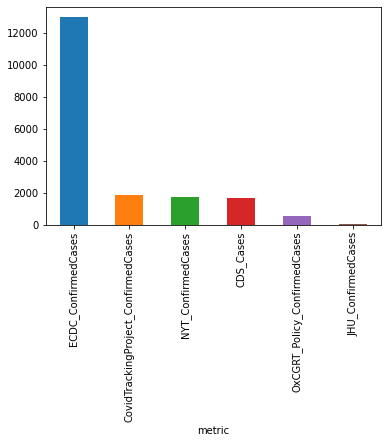

In [173]:
# finding out the missing values for each metric
statsConfirmed.groupby("metric")["noOfDaysDataMissn"].sum().sort_values(ascending=False).plot(kind="bar")

##### dropping metric ECDC_ConfirmedCases

In [174]:
# ignoreing the metric ECDC_ConfirmedCases --> data missing for all 249 days --> it is a european source
statsConfirmed = statsConfirmed[statsConfirmed.metric != "ECDC_ConfirmedCases"]

##### checking for neg flag counts for each metric

<AxesSubplot:xlabel='metric'>

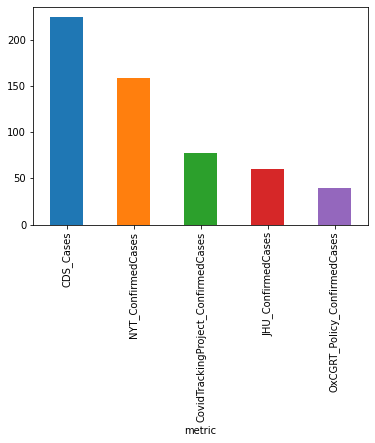

In [175]:
statsConfirmed.groupby("metric")["negFlagCount"].sum().sort_values(ascending=False).plot(kind="bar")

Text(0, 0.5, 'num of states with Neg flag')

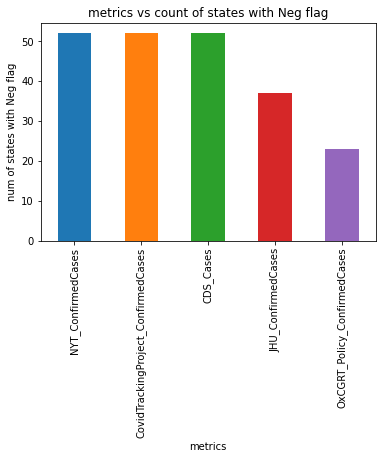

In [176]:
negFlagData = statsConfirmed[statsConfirmed["negFlagCount"]!=0]
negFlagData.groupby("metric")["state"].count().sort_values(ascending=False).plot(kind="bar")
plt.title( "metrics" + " vs " + "count of states with Neg flag")
plt.xlabel("metrics")
plt.ylabel("num of states with Neg flag")

Text(0, 0.5, 'count of Neg flag - for all sources')

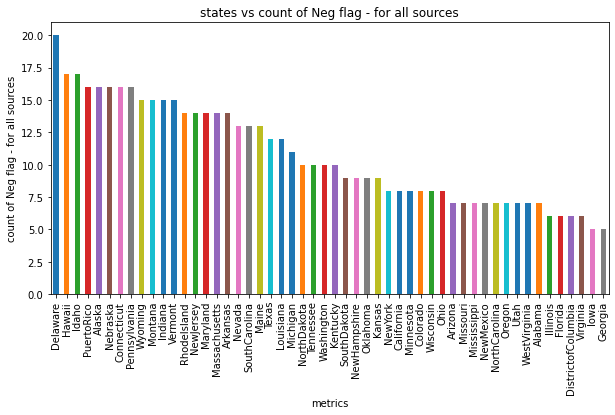

In [177]:
negFlagData.groupby("state")["negFlagCount"].sum().sort_values(ascending=False).plot(kind="bar", figsize=(10,5))
plt.title( "states" + " vs " + "count of Neg flag - for all sources")
plt.xlabel("metrics")
plt.ylabel("count of Neg flag - for all sources")

##### dropping metric CDS_Cases

In [178]:
# ignoreing the metric CDS_Cases --> due to high count of negative indicators
statsConfirmed = statsConfirmed[statsConfirmed.metric != "CDS_Cases"]

##### statewise comparison for metrics - NY vs CA

In [179]:
sttWise = statsConfirmed[statsConfirmed["state"].isin(["NewYork", "California"])]

In [180]:
sttWise.groupby("state").head(100)

,state,metric,count,mean,std,min,25%,50%,75%,max,negFlagCount,noOfDaysDataMissn
4,California,JHU_ConfirmedCases,249.0,268143.020080,293414.020295,3.0,12004.0,122168.0,530606.0,838202.0,0,0
32,NewYork,JHU_ConfirmedCases,249.0,287489.638554,174639.701401,0.0,102987.0,382663.0,425755.0,466908.0,1,0
4,California,CovidTrackingProject_ConfirmedCases,249.0,257910.112450,287023.999231,0.0,8155.0,115310.0,514901.0,823729.0,1,34
32,NewYork,CovidTrackingProject_ConfirmedCases,249.0,280580.056225,173766.046687,0.0,83712.0,373040.0,416843.0,464582.0,1,34
4,California,NYT_ConfirmedCases,249.0,259081.991968,288823.466834,0.0,8584.0,115643.0,515937.0,831447.0,1,3
32,NewYork,NYT_ConfirmedCases,249.0,284039.381526,175719.557720,0.0,84364.0,377881.0,421550.0,470244.0,3,31
4,California,OxCGRT_Policy_ConfirmedCases,249.0,267911.297189,293022.523231,3.0,12016.0,122194.0,530606.0,822205.0,0,5
32,NewYork,OxCGRT_Policy_ConfirmedCases,249.0,284322.815261,172552.937828,0.0,102987.0,375133.0,418225.0,460031.0,0,5


<br>Inference from comparing California and NewYork state specifically<br>  1. the distribution is almost similar for all metrics for NY and CA <br>  2. However, number of days data is missing --> is high for "CovidTrackingProject_ConfirmedCases" in NY and CA <br>  3. 31 days of missing data from "NYT_ConfirmedCases" in NY <br>  4. JHU_ConfirmedCases and OxCGRT_Policy_ConfirmedCases seems to be more reliable

In [181]:
# inputs for getting correlation matrix from all sources
metricList = ["JHU_ConfirmedCases", "CovidTrackingProject_ConfirmedCases", "NYT_ConfirmedCases", "CDS_Cases", "OxCGRT_Policy_ConfirmedCases"]
corr, agg = corrMatrixStateWise(data, metricList)       

In [182]:
agg

,JHU_ConfirmedCases,CovidTrackingProject_ConfirmedCases,NYT_ConfirmedCases,CDS_Cases,OxCGRT_Policy_ConfirmedCases
JHU_ConfirmedCases,1.000000,0.959411,0.954603,0.923185,NaN
CovidTrackingProject_ConfirmedCases,0.959411,1.000000,0.964083,0.902115,NaN
NYT_ConfirmedCases,0.954603,0.964083,1.000000,0.897588,NaN
CDS_Cases,0.923185,0.902115,0.897588,1.000000,NaN
OxCGRT_Policy_ConfirmedCases,NaN,NaN,NaN,NaN,NaN


<br> 1. Highest correlation - NYT and Covid Tracking <br> 2. OxCGRT_Policy_ConfirmedCases has NaN values --> need to check data

In [183]:
metricList = ['JHU_ConfirmedCases', "OxCGRT_Policy_ConfirmedCases"]
corr, agg = corrMatrixStateWise(data, metricList)

In [184]:
agg

,JHU_ConfirmedCases,OxCGRT_Policy_ConfirmedCases
JHU_ConfirmedCases,1.0,NaN
OxCGRT_Policy_ConfirmedCases,NaN,NaN


<br> OxCGRT_Policy_ConfirmedCases - data missing for District of Columbia (Washington DC) <br>

In [185]:
metricList = ['JHU_ConfirmedCases', "CovidTrackingProject_ConfirmedCases", "NYT_ConfirmedCases", "CDS_Cases"]
corr, agg = corrMatrixStateWise(data, metricList)

In [186]:
agg

,JHU_ConfirmedCases,CovidTrackingProject_ConfirmedCases,NYT_ConfirmedCases,CDS_Cases
JHU_ConfirmedCases,1.000000,0.959411,0.954603,0.923185
CovidTrackingProject_ConfirmedCases,0.959411,1.000000,0.964083,0.902115
NYT_ConfirmedCases,0.954603,0.964083,1.000000,0.897588
CDS_Cases,0.923185,0.902115,0.897588,1.000000


In [187]:
agg.sum()/4

JHU_ConfirmedCases                     0.959300
CovidTrackingProject_ConfirmedCases    0.956403
NYT_ConfirmedCases                     0.954068
CDS_Cases                              0.930722
dtype: float64

### Generate report for tested cases

In [188]:
with c3_open("columns-SourceData.csv", 'r') as f:
    columnsMastData = pd.read_csv(f, )

In [189]:
columnsMastData[columnsMastData["Tested"]=="Tested"]

,Columns,Metric Type,Tested
2,JHU_ConfirmedCases,Confirmed,Tested
8,CovidTrackingProject_ConfirmedCases,Confirmed,Tested
14,CovidTrackingProject_NegativeTests,Negative,Tested
16,CovidTrackingProject_PendingTests,Pending,Tested
18,ECDC_ConfirmedCases,Confirmed,Tested
22,NYT_ConfirmedCases,Confirmed,Tested
46,CDS_Tested,Tested,Tested
414,OxCGRT_Policy_ConfirmedCases,Confirmed,Tested


In [190]:
data["JHU_Tested"] = data["JHU_ConfirmedCases"]
data["CovidTrackingProject_Tested"] = data["CovidTrackingProject_ConfirmedCases"] + data["CovidTrackingProject_NegativeTests"] + data["CovidTrackingProject_PendingTests"]
data["ECDC_Tested"] = data["ECDC_ConfirmedCases"]
data["NYT_Tested"] = data["NYT_ConfirmedCases"]
data["OxCGRT_Policy_Tested"] = data["OxCGRT_Policy_ConfirmedCases"]

data["JHU_Tested.missing"] = data["JHU_ConfirmedCases.missing"]
data["CovidTrackingProject_Tested.missing"] = data["CovidTrackingProject_ConfirmedCases.missing"] + data["CovidTrackingProject_NegativeTests.missing"] + data["CovidTrackingProject_PendingTests.missing"]
data["ECDC_Tested.missing"] = data["ECDC_ConfirmedCases.missing"]
data["NYT_Tested.missing"] = data["NYT_ConfirmedCases.missing"]
data["OxCGRT_Policy_Tested.missing"] = data["OxCGRT_Policy_ConfirmedCases.missing"]

# getting the stats for tested cases # find out all the metrics having tested cases. which source to use ?
metricList = ["JHU_Tested", "CovidTrackingProject_Tested", "ECDC_Tested", "NYT_Tested", "OxCGRT_Policy_Tested", "CDS_Tested"]

In [191]:
# finding the descriptive stats
data, statsTested = descriptiveStatForMetrics(data, metricList)

<AxesSubplot:xlabel='metric'>

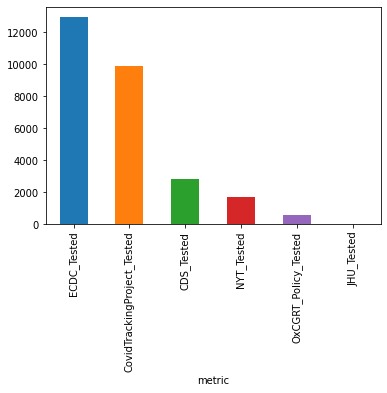

In [192]:
# finding out the missing values for each metric
statsTested.groupby("metric")["noOfDaysDataMissn"].sum().sort_values(ascending=False).plot(kind="bar")

##### dropping metric ECDC_Tested

In [193]:
# ignoreing the metric ECDC_statsTested --> data missing for all 249 days --> it is a european source
statsTested = statsTested[statsTested.metric != "ECDC_Tested"]

##### checking for neg flag counts for each metric

<AxesSubplot:xlabel='metric'>

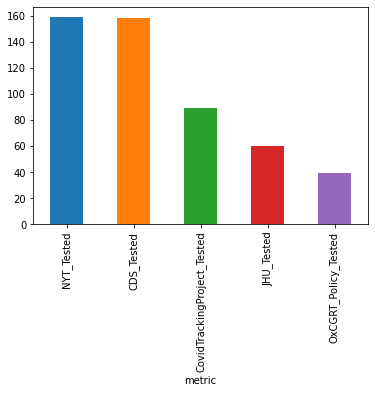

In [194]:
statsTested.groupby("metric")["negFlagCount"].sum().sort_values(ascending=False).plot(kind="bar")

Text(0, 0.5, 'num of states with Neg flag')

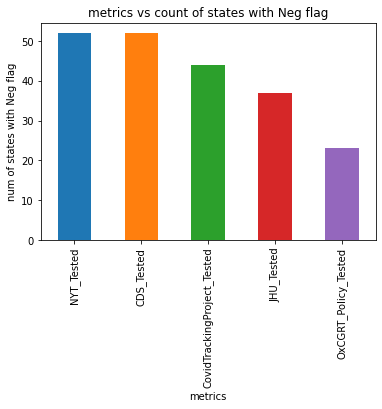

In [195]:
negFlagData = statsTested[statsTested["negFlagCount"]!=0]
negFlagData.groupby("metric")["state"].count().sort_values(ascending=False).plot(kind="bar")
plt.title( "metrics" + " vs " + "count of states with Neg flag")
plt.xlabel("metrics")
plt.ylabel("num of states with Neg flag")

Text(0, 0.5, 'count of Neg flag - for all sources')

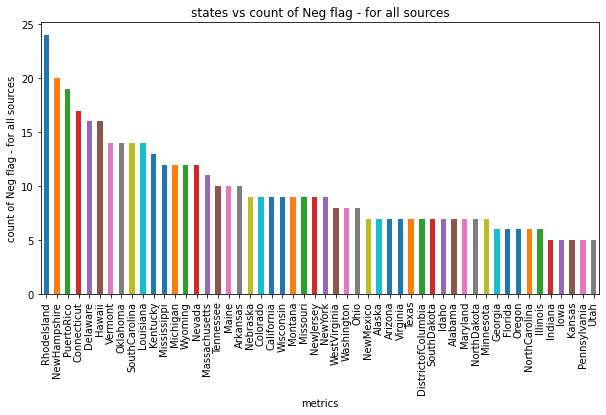

In [196]:
negFlagData.groupby("state")["negFlagCount"].sum().sort_values(ascending=False).plot(kind="bar", figsize=(10,5))
plt.title( "states" + " vs " + "count of Neg flag - for all sources")
plt.xlabel("metrics")
plt.ylabel("count of Neg flag - for all sources")

##### dropping metric CDS_Tested and NYT_Tested

In [197]:
# ignoreing the metric NYT_Tested, CDS_Tested --> due to high count of negative indicators
statsTested = statsTested[(statsTested.metric != "NYT_Tested")& (statsTested.metric != "CDS_Tested")]

##### statewise comparison for metrics - NY vs CA

In [198]:
sttWise = statsTested[statsTested["state"].isin(["NewYork", "California"])]

In [199]:
sttWise.groupby("state").head(100)

,state,metric,count,mean,std,min,25%,50%,75%,max,negFlagCount,noOfDaysDataMissn
4,California,JHU_Tested,249.0,2.681430e+05,2.934140e+05,3.0,12004.0,122168.0,530606.0,838202.0,0,0
32,NewYork,JHU_Tested,249.0,2.874896e+05,1.746397e+05,0.0,102987.0,382663.0,425755.0,466908.0,1,0
4,California,CovidTrackingProject_Tested,249.0,3.118407e+07,3.713879e+07,0.0,94800.0,2182671.0,62609239.0,111533698.0,3,169
32,NewYork,CovidTrackingProject_Tested,249.0,3.030453e+07,3.579303e+07,0.0,260520.0,2293032.0,60426274.0,107594031.0,2,193
4,California,OxCGRT_Policy_Tested,249.0,2.679113e+05,2.930225e+05,3.0,12016.0,122194.0,530606.0,822205.0,0,5
32,NewYork,OxCGRT_Policy_Tested,249.0,2.843228e+05,1.725529e+05,0.0,102987.0,375133.0,418225.0,460031.0,0,5


<br>Inference from comparing California and NewYork state specifically<br>  1. the distribution is almost similar for JHU and OxCGRT for NY and CA <br>  2. Number of days data is missing --> is high for "CovidTrackingProject_ConfirmedCases" in NY and CA <br> 3. JHU_ConfirmedCases and OxCGRT_Policy_ConfirmedCases seems to be more reliable

In [200]:
# inputs for getting correlation matrix from all sources
metricList = ["JHU_Tested", "CovidTrackingProject_Tested", "NYT_Tested", "CDS_Tested", "OxCGRT_Policy_Tested"]
corr, agg = corrMatrixStateWise(data, metricList)       

In [201]:
agg

,JHU_Tested,CovidTrackingProject_Tested,NYT_Tested,CDS_Tested,OxCGRT_Policy_Tested
JHU_Tested,1.000000,0.940455,0.954603,0.599159,NaN
CovidTrackingProject_Tested,0.940455,1.000000,0.896098,0.605350,NaN
NYT_Tested,0.954603,0.896098,1.000000,0.614315,NaN
CDS_Tested,0.599159,0.605350,0.614315,1.000000,NaN
OxCGRT_Policy_Tested,NaN,NaN,NaN,NaN,NaN


<br> 1. Highest correlation - JHU and Covid Tracking <br> 2. OxCGRT_Policy_ConfirmedCases has NaN values --> need to check data - because data not available for Washington D.C.

In [202]:
agg.sum()/4

JHU_Tested                     0.873554
CovidTrackingProject_Tested    0.860476
NYT_Tested                     0.866254
CDS_Tested                     0.704706
OxCGRT_Policy_Tested           0.000000
dtype: float64

Most reliable source for Tested cases is JHU and OxCGRT<\br> <br> But OxCGRT has no data for Washington D.C. <br>

<br>

### Generate report for death cases

In [203]:
# find out all the metrics having death cases
columnsMastData[columnsMastData["Metric Type"]=="Death"]

,Columns,Metric Type,Tested
4,JHU_ConfirmedDeaths,Death,NaN
10,CovidTrackingProject_ConfirmedDeaths,Death,NaN
20,ECDC_ConfirmedDeaths,Death,NaN
24,NYT_ConfirmedDeaths,Death,NaN
34,CDS_Deaths,Death,NaN
416,OxCGRT_Policy_ConfirmedDeaths,Death,NaN


In [204]:
# getting the stats for tested cases # find out all the metrics having tested cases. which source to use ?
metricList = ["JHU_ConfirmedDeaths", "CovidTrackingProject_ConfirmedDeaths", "ECDC_ConfirmedDeaths", "NYT_ConfirmedDeaths", "CDS_Deaths", "OxCGRT_Policy_ConfirmedDeaths"]

In [205]:
# finding the descriptive stats
data, statsDeath = descriptiveStatForMetrics(data, metricList)

<AxesSubplot:xlabel='metric'>

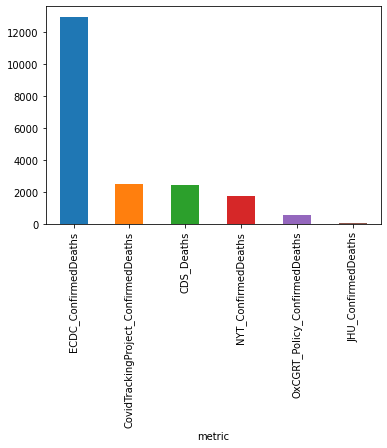

In [206]:
# finding out the missing values for each metric
statsDeath.groupby("metric")["noOfDaysDataMissn"].sum().sort_values(ascending=False).plot(kind="bar")

##### dropping metric ECDC_ConfirmedDeaths

In [207]:
# ignoreing the metric ECDC_statsTested --> data missing for all 249 days --> it is a european source
statsDeath = statsDeath[statsDeath.metric != "ECDC_ConfirmedDeaths"]

##### checking for neg flag counts for each metric

<AxesSubplot:xlabel='metric'>

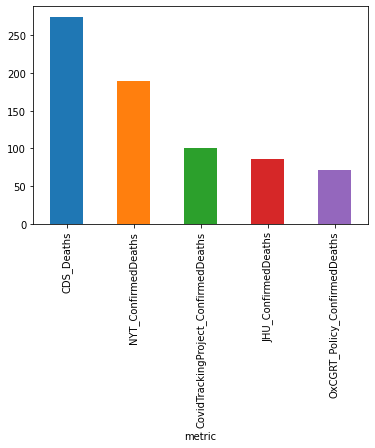

In [208]:
statsDeath.groupby("metric")["negFlagCount"].sum().sort_values(ascending=False).plot(kind="bar")

Text(0, 0.5, 'num of states with Neg flag')

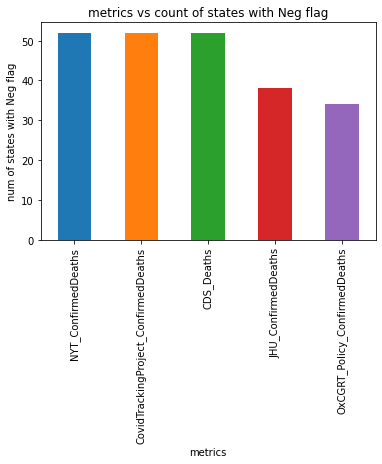

In [209]:
negFlagData = statsDeath[statsDeath["negFlagCount"]!=0]
negFlagData.groupby("metric")["state"].count().sort_values(ascending=False).plot(kind="bar")
plt.title( "metrics" + " vs " + "count of states with Neg flag")
plt.xlabel("metrics")
plt.ylabel("num of states with Neg flag")

Text(0, 0.5, 'count of Neg flag - for all sources')

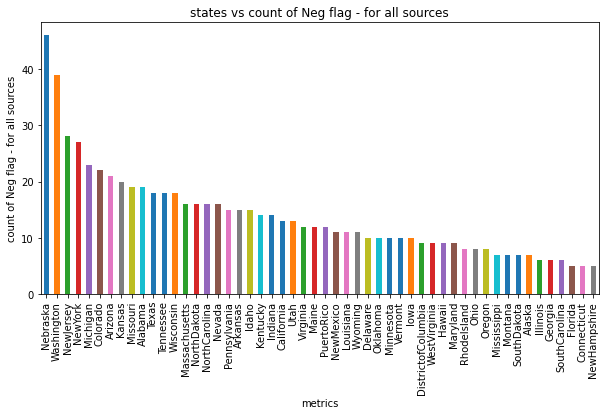

In [210]:
negFlagData.groupby("state")["negFlagCount"].sum().sort_values(ascending=False).plot(kind="bar", figsize=(10,5))
plt.title( "states" + " vs " + "count of Neg flag - for all sources")
plt.xlabel("metrics")
plt.ylabel("count of Neg flag - for all sources")

##### dropping metric CDS_Deaths and NYT_ConfirmedDeaths

In [211]:
# ignoreing the metric NYT_Tested, CDS_Tested --> due to high count of negative indicators
statsDeath = statsDeath[(statsDeath.metric != "CDS_Deaths")& (statsDeath.metric != "NYT_ConfirmedDeaths")]

##### statewise comparison for metrics - NY vs CA

In [212]:
sttWise = statsDeath[statsDeath["state"].isin(["NewYork", "California"])]

In [213]:
sttWise.groupby("state").head(100)

,state,metric,count,mean,std,min,25%,50%,75%,max,negFlagCount,noOfDaysDataMissn
4,California,JHU_ConfirmedDeaths,249.0,5626.020080,5315.344702,0.0,265.0,4444.0,9808.0,16244.0,3,0
32,NewYork,JHU_ConfirmedDeaths,249.0,21712.056225,13850.490156,0.0,2935.0,30219.0,32799.0,33219.0,5,0
4,California,CovidTrackingProject_ConfirmedDeaths,249.0,5444.570281,5218.701042,0.0,171.0,4286.0,9388.0,16120.0,1,42
32,NewYork,CovidTrackingProject_ConfirmedDeaths,249.0,16776.208835,10750.347891,0.0,1941.0,24023.0,25172.0,25519.0,1,45
4,California,OxCGRT_Policy_ConfirmedDeaths,249.0,5621.244980,5308.361827,0.0,265.0,4444.0,9808.0,15973.0,2,5
32,NewYork,OxCGRT_Policy_ConfirmedDeaths,249.0,22180.020080,13719.205375,0.0,4899.0,31093.0,32736.0,33159.0,5,5


<br>Inference from comparing California and NewYork state specifically<br>  1. the distribution is almost similar for JHU and OxCGRT for NY and CA <br>  2. Number of days data is missing --> is high for "CovidTrackingProject_ConfirmedCases" in NY and CA <br> 3. JHU_ConfirmedCases and OxCGRT_Policy_ConfirmedCases seems to be more reliable

In [214]:
# inputs for getting correlation matrix from all sources
metricList = ["JHU_ConfirmedDeaths", "CovidTrackingProject_ConfirmedDeaths", "NYT_ConfirmedDeaths", "CDS_Deaths", "OxCGRT_Policy_ConfirmedDeaths"]
corr, agg = corrMatrixStateWise(data, metricList)       

In [215]:
agg

,JHU_ConfirmedDeaths,CovidTrackingProject_ConfirmedDeaths,NYT_ConfirmedDeaths,CDS_Deaths,OxCGRT_Policy_ConfirmedDeaths
JHU_ConfirmedDeaths,1.000000,0.962374,0.934329,0.927562,NaN
CovidTrackingProject_ConfirmedDeaths,0.962374,1.000000,0.944477,0.909307,NaN
NYT_ConfirmedDeaths,0.934329,0.944477,1.000000,0.882080,NaN
CDS_Deaths,0.927562,0.909307,0.882080,1.000000,NaN
OxCGRT_Policy_ConfirmedDeaths,NaN,NaN,NaN,NaN,NaN


<br> 1. Highest correlation - JHU and Covid Tracking <br> 2. OxCGRT_Policy_ConfirmedDeaths has NaN values --> need to check data - because data not available for Washington D.C.

In [216]:
agg.sum()/4

JHU_ConfirmedDeaths                     0.956066
CovidTrackingProject_ConfirmedDeaths    0.954040
NYT_ConfirmedDeaths                     0.940222
CDS_Deaths                              0.929737
OxCGRT_Policy_ConfirmedDeaths           0.000000
dtype: float64

Most reliable source for Deaths cases is JHU and OxCGRT<\br> <br> But OxCGRT has no data for Washington D.C. <br>

<br>

### Generate report for recovered cases

In [217]:
# find out all the metrics having recovered cases

In [218]:
# find out all the metrics having death cases
columnsMastData[columnsMastData["Metric Type"]=="Recovered"]

,Columns,Metric Type,Tested
6,JHU_ConfirmedRecoveries,Recovered,NaN
36,CDS_Discharged,Recovered,NaN
44,CDS_Recovered,Recovered,NaN


In [219]:
# getting the stats for tested cases # find out all the metrics having tested cases. which source to use ?
metricList = ["JHU_ConfirmedRecoveries", "CDS_Recovered"]

In [220]:
# finding the descriptive stats
data, statsRecovered = descriptiveStatForMetrics(data, metricList)

<AxesSubplot:xlabel='metric'>

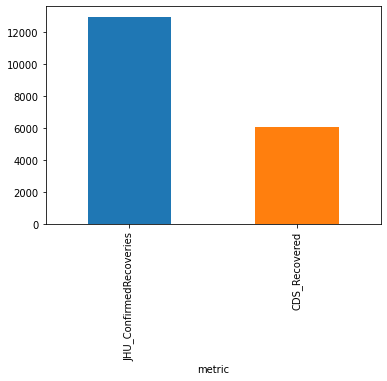

In [221]:
# finding out the missing values for each metric
statsRecovered.groupby("metric")["noOfDaysDataMissn"].sum().sort_values(ascending=False).plot(kind="bar")

##### checking for neg flag counts for each metric

<AxesSubplot:xlabel='metric'>

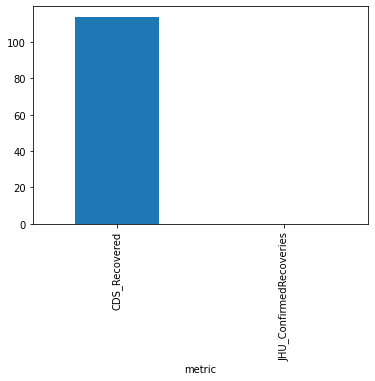

In [222]:
statsRecovered.groupby("metric")["negFlagCount"].sum().sort_values(ascending=False).plot(kind="bar")

Text(0, 0.5, 'num of states with Neg flag')

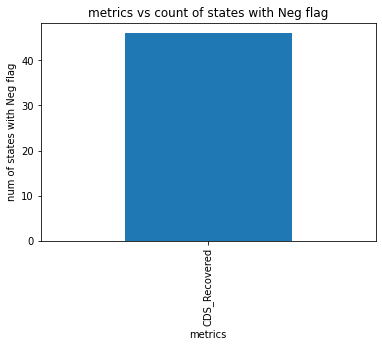

In [223]:
negFlagData = statsRecovered[statsRecovered["negFlagCount"]!=0]
negFlagData.groupby("metric")["state"].count().sort_values(ascending=False).plot(kind="bar")
plt.title( "metrics" + " vs " + "count of states with Neg flag")
plt.xlabel("metrics")
plt.ylabel("num of states with Neg flag")

Text(0, 0.5, 'count of Neg flag - for all sources')

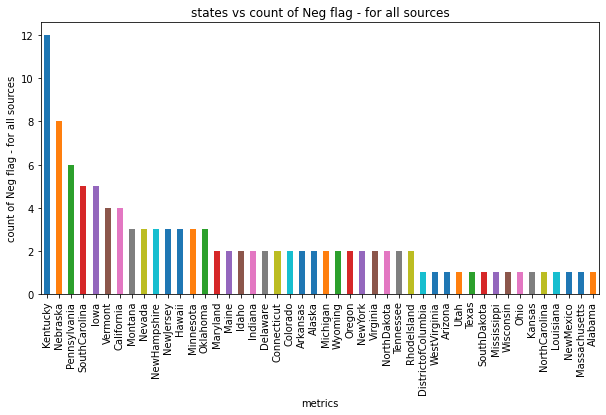

In [224]:
negFlagData.groupby("state")["negFlagCount"].sum().sort_values(ascending=False).plot(kind="bar", figsize=(10,5))
plt.title( "states" + " vs " + "count of Neg flag - for all sources")
plt.xlabel("metrics")
plt.ylabel("count of Neg flag - for all sources")

##### statewise comparison for metrics - NY vs CA

In [225]:
sttWise = statsRecovered[statsRecovered["state"].isin(["NewYork", "California"])]

In [226]:
sttWise.groupby("state").head(100)

,state,metric,count,mean,std,min,25%,50%,75%,max,negFlagCount,noOfDaysDataMissn
4,California,JHU_ConfirmedRecoveries,249.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0,249
32,NewYork,JHU_ConfirmedRecoveries,249.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0,249
4,California,CDS_Recovered,249.0,43926.481928,76037.286250,0.0,0.0,5130.0,45480.0,319249.0,4,82
32,NewYork,CDS_Recovered,249.0,40462.236948,32683.058796,0.0,0.0,58363.0,71279.0,75539.0,2,82


<br>Inference from comparing California and NewYork state specifically<br>  1. data is completed missing from JHU source <br>  2. Number of days data is missing --> is high for "JHU_ConfirmedRecoveries" in NY and CA <br> 3. CDS_Recovered is more reliable

In [227]:
# inputs for getting correlation matrix from all sources
metricList = ["JHU_ConfirmedRecoveries", "CDS_Recovered"]
corr, agg = corrMatrixStateWise(data, metricList)       

In [228]:
agg

,JHU_ConfirmedRecoveries,CDS_Recovered
JHU_ConfirmedRecoveries,NaN,NaN
CDS_Recovered,NaN,NaN


<br> NaN because values are completely missing from JHU sources of recoveries

Most reliable source for Recovered cases is CDS_Recovered <br>

<br>

### Generate report for hospitalized cases

In [230]:
columnsMastData[columnsMastData["Metric Type"]=="Hospitalized"]

,Columns,Metric Type,Tested
12,CovidTrackingProject_ConfirmedHospitalizations,Hospitalized,NaN
40,CDS_Hospitalized,Hospitalized,NaN
42,CDS_ICU,Hospitalized,NaN


In [231]:
# getting the stats for hospitalised cases # find out all the metrics having hospitalised cases. which source to use ?
metricList = ["CovidTrackingProject_ConfirmedHospitalizations", "CDS_Hospitalized"]

In [232]:
# finding the descriptive stats
data, statsHosp = descriptiveStatForMetrics(data, metricList)

<AxesSubplot:xlabel='metric'>

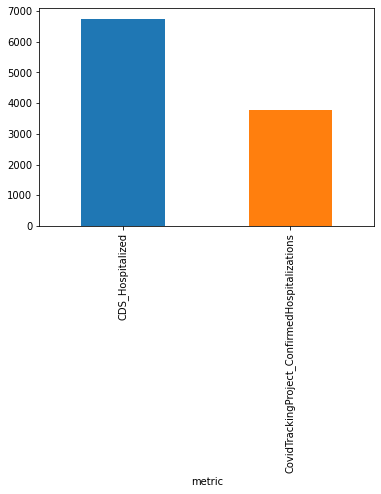

In [233]:
# finding out the missing values for each metric
statsHosp.groupby("metric")["noOfDaysDataMissn"].sum().sort_values(ascending=False).plot(kind="bar")

##### checking for neg flag counts for each metric

<AxesSubplot:xlabel='metric'>

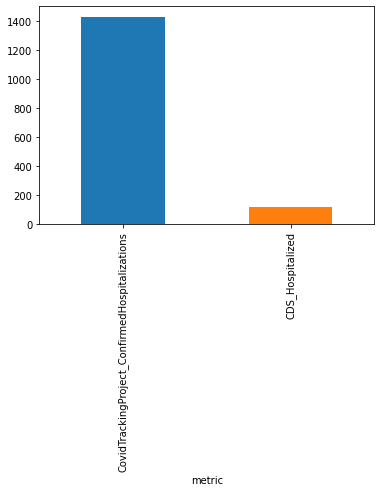

In [234]:
statsHosp.groupby("metric")["negFlagCount"].sum().sort_values(ascending=False).plot(kind="bar")

Text(0, 0.5, 'num of states with Neg flag')

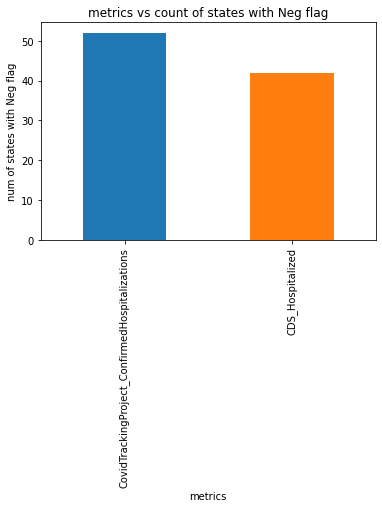

In [235]:
negFlagData = statsHosp[statsHosp["negFlagCount"]!=0]
negFlagData.groupby("metric")["state"].count().sort_values(ascending=False).plot(kind="bar")
plt.title( "metrics" + " vs " + "count of states with Neg flag")
plt.xlabel("metrics")
plt.ylabel("num of states with Neg flag")

Text(0, 0.5, 'count of Neg flag - for all sources')

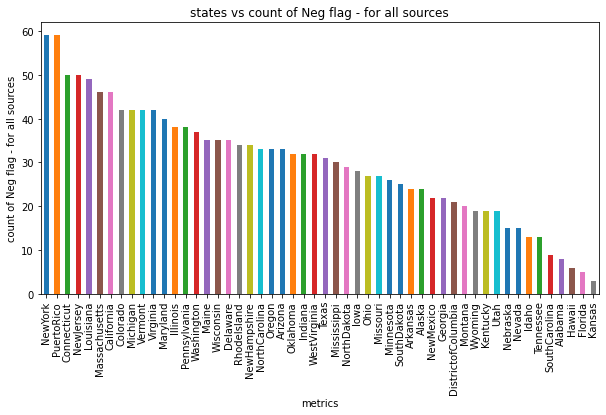

In [236]:
negFlagData.groupby("state")["negFlagCount"].sum().sort_values(ascending=False).plot(kind="bar", figsize=(10,5))
plt.title( "states" + " vs " + "count of Neg flag - for all sources")
plt.xlabel("metrics")
plt.ylabel("count of Neg flag - for all sources")

##### statewise comparison for metrics - NY vs CA

In [237]:
sttWise = statsHosp[statsHosp["state"].isin(["NewYork", "California"])]

In [238]:
sttWise.groupby("state").head(100)

,state,metric,count,mean,std,min,25%,50%,75%,max,negFlagCount,noOfDaysDataMissn
4,California,CovidTrackingProject_ConfirmedHospitalizations,249.0,156435.192771,168179.470367,0.0,2188.0,4984.0,327258.0,416678.0,33,55
32,NewYork,CovidTrackingProject_ConfirmedHospitalizations,249.0,155888.666667,164265.044368,0.0,3331.0,18279.0,320270.0,415085.0,58,45
4,California,CDS_Hospitalized,249.0,3124.787149,3042.115162,0.0,0.0,3022.0,5402.0,9651.0,13,97
32,NewYork,CDS_Hospitalized,249.0,54046.200803,40960.333202,0.0,0.0,82730.0,89995.0,89995.0,1,76


<br>Inference from comparing California and NewYork state specifically<br>  1. the distribution is NOT similar for CDS and Covid Tracking hospitalised for NY and CA <br>  2. Number of days data is missing --> is high for "CDS_Hospitalized" in NY and CA <br> 3. Neg flag count is high for CovidTrackingProject_ConfirmedHospitalizations

In [239]:
# inputs for getting correlation matrix from all sources
metricList = ["CovidTrackingProject_ConfirmedHospitalizations", "CDS_Hospitalized"]
corr, agg = corrMatrixStateWise(data, metricList)       

In [240]:
agg

,CovidTrackingProject_ConfirmedHospitalizations,CDS_Hospitalized
CovidTrackingProject_ConfirmedHospitalizations,1.0,NaN
CDS_Hospitalized,NaN,NaN


<br> 1. CDS_Hospitalized has NaN values --> data could be completely missing for a few states

In [241]:
data.groupby("state")[["CovidTrackingProject_ConfirmedHospitalizations", "CDS_Hospitalized"]].sum().head()

,CovidTrackingProject_ConfirmedHospitalizations,CDS_Hospitalized
state,,
Alabama,38094891,860935
Alaska,37969884,688
Arizona,38209219,1241447
Arkansas,38019310,267673
California,38952363,778072


<br> Most reliable source for hospitalized cases is CovidTrackingProject_ConfirmedHospitalizations than CDS_Hospitalized